In [1]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [83]:
print('# 설정되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )
plt.rcParams["font.family"] = 'NanumGothic'
print (plt.rcParams['font.family'] )

# 설정되어있는 폰트 글꼴
['Nanum Brush Script OTF']
['NanumGothic']


In [2]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [3]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [8]:
X_test = np.load('save_data/result_data/X_test.npy')
y_test = np.load('save_data/result_data/y_test.npy')
facs_test = np.load('save_data/result_data/facs_test.npy')
feature_test = np.load('save_data/result_data/feature_test.npy')

In [10]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(16, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [11]:
dense_model = make_model()

In [12]:
json_file = open('result/dense_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dense_model = model_from_json(loaded_model_json)
# load weights into new model
dense_model.load_weights("result/dense_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [14]:
facs_pred = dense_model.predict(feature_test)

In [15]:
facs_pred

array([[9.60195959e-01, 5.00013269e-02, 1.00862104e-02, ...,
        2.96726241e-03, 9.22204833e-03, 2.51815934e-03],
       [8.73735309e-01, 5.77509683e-03, 3.54281277e-04, ...,
        1.48559123e-01, 4.89145368e-02, 9.47269320e-04],
       [9.51964259e-01, 2.59452499e-02, 1.16723042e-03, ...,
        4.24960218e-02, 1.52756064e-03, 1.62406839e-04],
       ...,
       [3.04721785e-03, 9.99800384e-01, 9.99953747e-01, ...,
        1.22645361e-06, 9.99944448e-01, 9.98040855e-01],
       [2.30621221e-03, 5.58837064e-06, 1.17061245e-04, ...,
        1.49694324e-01, 1.09033613e-02, 7.11344939e-04],
       [8.24872613e-01, 1.78885553e-02, 8.00526980e-03, ...,
        7.34647969e-03, 6.99351588e-03, 5.82873449e-03]], dtype=float32)

In [16]:
facs_pred_int = []
for inst in facs_pred:
    temp_inst = []
    for elem in inst:
        if elem > 0.5:
            temp_inst.append(1)
        else:
            temp_inst.append(0)
    facs_pred_int.append(temp_inst)

In [17]:
facs_pred_np = np.array(facs_pred_int, dtype=int)

In [18]:
facs_accuracy = {}
for code_num in facs.columns:
    facs_accuracy[int(code_num)] = 0

In [20]:
for i in range(facs_pred_np.shape[0]):
    for j in range(facs_pred_np.shape[1]):
        if facs_pred_np[i][j] == facs_test[i][j]:
            facs_accuracy[int(facs.columns[j])] +=1

In [21]:
facs_accuracy = pd.DataFrame(facs_accuracy, index=range(1))

In [23]:
X_test.shape

(262, 1, 96, 96)

In [70]:
emotion_list = ['Neutral','Angry', 'Contempt', 'Disgust', 'Fear', 'Happy',
                          'Sadness', 'Surprise']
au_str_list = [
'No AU',
'AU 1',
 'AU 2',
 'AU 4',
 'AU 5',
 'AU 6',
 'AU 7',
 'AU 9',
 'AU 12',
 'AU 15',
 'AU 17',
 'AU 20',
 'AU 23',
 'AU 24',
 'AU 25',
 'AU 27']


au_korean = [
    '안면 근육 움직임이 없기 때문이다.',
    '속눈썹이 올라갔고, ',
    '눈썹이 올라갔고, ',
    '눈썹이 내려갔고, ',
    '눈꺼풀이 올라갔고, ',
    '광대가 올라갔고, ',
    '눈을 게슴츠레 떴으며,',
    '코를 찡그렸으며, ',
    '입꼬리가 올라갔으며, ',
    '입꼬리가 내려갔고, ',
    '턱이 올라갔으며, ',
    '입을 가로로 늘어났고, ',
    '입을 내밀었으며, ',
    '입을 앙다물고, ',
    '입이 살짝 벌어지고, ',
    '입을 크게 벌리고'
]


au_korean_last = [
    '안면 근육 움직임이 없기 때문이다.',
    '속눈썹이 올라갔기 때문이다.',
    '눈썹이 올라갔기 때문이다.',
    '눈썹이 내려갔기 때문이다.',
    '눈꺼풀이 올라갔기 때문이다.',
    '광대가 올라갔기 때문이다.',
    '눈을 게슴츠레 떴기 때문이다.',
    '코를 찡그렸기 때문이다.',
    '입꼬리가 올라갔기 때문이다.',
    '입꼬리가 내려갔기 때문이다.',
    '턱을 올렸기 때문이다.',
    '입을 가로로 늘어났기 때문이다.',
    '입을 내밀었기 때문이다.',
    '입을 앙다물었기 때문이다.',
    '입이 살짝 벌어졌기 때문이다.',
    '입을 크게 벌렸기 때문이다.'
]

In [26]:
test_images = np.ndarray((262,96,96))
for index, test_image in enumerate(X_test):
    test_images[index] = test_image.reshape((96,96))

In [27]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

au_list = [1,2,4,5,6,7,9,12,15,17,20,23,24,25,27]
au_img = {}
for index, au_code in enumerate(au_list):
    loaded_au_img = load_img('action_unit/AU'+str(au_code)+'.png')
    loaded_au_arr = img_to_array(loaded_au_img)
    loaded_au_arr = loaded_au_arr.astype(np.int)
    au_img[index+1] = loaded_au_arr

In [28]:
test_images.shape

(262, 96, 96)

In [29]:
y_label_test = np.argmax(y_test,axis=1)

In [30]:
y_label_test

array([0, 0, 0, 0, 7, 5, 5, 7, 5, 7, 1, 7, 0, 0, 4, 0, 5, 0, 0, 4, 3, 4,
       0, 0, 7, 0, 2, 4, 5, 0, 3, 5, 3, 5, 3, 5, 4, 0, 7, 1, 1, 6, 0, 0,
       3, 0, 7, 7, 0, 7, 6, 3, 1, 0, 3, 3, 1, 3, 5, 0, 1, 5, 0, 5, 0, 6,
       3, 0, 5, 0, 0, 6, 0, 0, 6, 6, 0, 7, 3, 7, 0, 3, 6, 7, 7, 5, 2, 6,
       4, 1, 5, 1, 3, 7, 7, 2, 0, 1, 0, 1, 4, 3, 4, 1, 5, 1, 3, 6, 7, 3,
       5, 7, 7, 5, 0, 7, 4, 3, 0, 7, 4, 5, 1, 1, 0, 7, 1, 0, 7, 5, 0, 3,
       5, 1, 3, 4, 0, 3, 3, 3, 2, 7, 5, 1, 5, 3, 7, 0, 2, 1, 3, 0, 7, 0,
       0, 5, 0, 7, 4, 0, 1, 1, 3, 3, 6, 0, 5, 7, 7, 3, 4, 5, 5, 6, 2, 7,
       7, 7, 7, 5, 1, 0, 7, 7, 5, 3, 5, 6, 7, 4, 6, 7, 6, 0, 0, 0, 0, 0,
       7, 0, 5, 3, 0, 1, 5, 7, 7, 2, 1, 5, 0, 7, 3, 4, 0, 5, 7, 1, 7, 7,
       7, 1, 7, 0, 7, 0, 1, 7, 5, 2, 5, 3, 2, 6, 6, 0, 1, 7, 3, 0, 6, 3,
       0, 5, 5, 5, 3, 7, 1, 5, 1, 2, 5, 0, 5, 1, 7, 6, 3, 7, 3, 0])

In [31]:
label_pred = np.zeros((262))
for index,feature_label in enumerate(feature_test):
    label_pred[index] = np.argmax(feature_label[-8:], axis=0)
label_pred = label_pred.astype(int)

In [32]:
def facs_to_label(facs):
    facs_label = []
    for facs_elem in facs:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [37]:
def facs_test_to_label(facs):
    facs_label = []
    for facs_elem in facs:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [34]:
facs_pred_label = facs_to_label(facs_pred_np)

In [35]:
facs_pred_label

[[0],
 [0],
 [0],
 [0],
 [1, 2, 14, 15],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [3, 6, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [0],
 [1, 2, 4, 14],
 [0],
 [14],
 [0],
 [0],
 [1, 3, 4, 11, 14],
 [3, 5, 6, 7, 10],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [1, 2, 4, 14, 15],
 [],
 [],
 [1, 2, 11, 14],
 [5, 8, 14],
 [0],
 [5, 6, 7, 10, 14],
 [5, 8, 14],
 [3, 5, 6, 7],
 [5, 8, 14],
 [7, 10],
 [5],
 [3, 6, 11, 14],
 [0],
 [1, 2, 4, 14, 15],
 [3, 6, 10, 12, 13],
 [3, 6, 10, 12, 13],
 [3, 10],
 [0],
 [0],
 [3, 6, 7],
 [0],
 [1, 2, 4, 14],
 [0],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 9, 10],
 [0],
 [3, 6, 10, 13],
 [0],
 [7, 10, 13],
 [3, 5, 6, 7, 10],
 [3, 10],
 [3, 5, 6, 7, 10],
 [5, 8, 14],
 [],
 [3, 6, 10, 12, 13],
 [5, 8, 14],
 [0],
 [5, 8, 14],
 [0],
 [3, 10],
 [],
 [0],
 [5, 8, 14],
 [0],
 [0],
 [1, 2, 9, 10],
 [0],
 [0],
 [1, 3, 10],
 [1, 3, 9, 10],
 [0],
 [1, 2, 4, 14, 15],
 [3, 5, 7, 10],
 [1, 2, 14, 15],
 [0],
 [3, 6, 7, 10, 13],
 [1, 3],
 [1, 2, 4, 14, 15]

In [38]:
facs_test_label = facs_test_to_label(facs_test)

In [39]:
facs_test_label

[[0],
 [0],
 [0],
 [0],
 [1, 2, 14, 15],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [0],
 [1, 2, 4, 11, 14],
 [0],
 [14],
 [0],
 [0],
 [1, 3, 4, 11, 14],
 [3, 5, 6, 7, 10],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [1, 2, 4, 14],
 [0],
 [],
 [1, 2, 11, 14],
 [5, 8, 14],
 [0],
 [1, 3, 6, 7],
 [5, 8, 14],
 [3, 5, 6, 7],
 [5, 8, 14],
 [7, 10],
 [5, 6],
 [3, 6, 11, 14],
 [0],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [3, 6, 10, 12, 13],
 [1, 3, 10],
 [0],
 [0],
 [3, 5, 6, 7, 10],
 [0],
 [1, 2, 4, 14],
 [],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 9, 10],
 [7, 9, 10],
 [3, 6, 10, 13],
 [0],
 [7, 9, 10, 13],
 [3, 5, 6, 7, 10],
 [3, 4, 7, 9, 10, 12],
 [3, 5, 6, 7, 10],
 [5, 8, 14],
 [0],
 [3, 6, 10, 13],
 [5, 8, 14],
 [0],
 [5, 8, 14],
 [0],
 [1, 3, 10],
 [3, 6, 7],
 [0],
 [5, 8, 14],
 [0],
 [0],
 [1, 2, 9, 10],
 [0],
 [0],
 [1, 3, 10],
 [1, 3, 9, 10],
 [0],
 [1, 2, 4, 14, 15],
 [3, 5, 7, 10],
 [1, 2, 14, 15],
 [0],
 [3, 6, 7, 10],

In [76]:
def make_facs_text(facs_label, a):
    facs_text = ''
    facs_label = facs_label
    facs_korean = '왜냐하면, '
    
    for index, facs_elem in enumerate(facs_label[a]):
        if facs_elem == 0:
            facs_text = 'no AU,'
            facs_korean += au_korean[facs_elem]
        elif index != len(facs_test_label[a])-1:
            try:
                facs_text += au_str_list[facs_elem] + ', '
                facs_korean += au_korean[facs_elem]
            except:
                print(facs_elem)
        else:
            facs_text += au_str_list[facs_elem]
            facs_korean += au_korean_last[facs_elem]

    return facs_text, facs_korean

In [59]:
facs_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [42]:
facs_test_label

[[0],
 [0],
 [0],
 [0],
 [1, 2, 14, 15],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [0],
 [1, 2, 4, 11, 14],
 [0],
 [14],
 [0],
 [0],
 [1, 3, 4, 11, 14],
 [3, 5, 6, 7, 10],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [1, 2, 4, 14],
 [0],
 [],
 [1, 2, 11, 14],
 [5, 8, 14],
 [0],
 [1, 3, 6, 7],
 [5, 8, 14],
 [3, 5, 6, 7],
 [5, 8, 14],
 [7, 10],
 [5, 6],
 [3, 6, 11, 14],
 [0],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [3, 6, 10, 12, 13],
 [1, 3, 10],
 [0],
 [0],
 [3, 5, 6, 7, 10],
 [0],
 [1, 2, 4, 14],
 [],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 9, 10],
 [7, 9, 10],
 [3, 6, 10, 13],
 [0],
 [7, 9, 10, 13],
 [3, 5, 6, 7, 10],
 [3, 4, 7, 9, 10, 12],
 [3, 5, 6, 7, 10],
 [5, 8, 14],
 [0],
 [3, 6, 10, 13],
 [5, 8, 14],
 [0],
 [5, 8, 14],
 [0],
 [1, 3, 10],
 [3, 6, 7],
 [0],
 [5, 8, 14],
 [0],
 [0],
 [1, 2, 9, 10],
 [0],
 [0],
 [1, 3, 10],
 [1, 3, 9, 10],
 [0],
 [1, 2, 4, 14, 15],
 [3, 5, 7, 10],
 [1, 2, 14, 15],
 [0],
 [3, 6, 7, 10],

In [43]:
emotion_list

['Neutral',
 'Angry',
 'Contempt',
 'Disgust',
 'Fear',
 'Happy',
 'Sadness',
 'Surprise']

In [71]:
au_korean[15]

'입을 크게 벌리고'

In [78]:
def plot_prediction(ax, a=0, c=c):
    facs_pred_text, facs_pred_korean = make_facs_text(facs_pred_label, a)
    facs_test_text, facs_test_korean = make_facs_text(facs_test_label, a)

    ax = plt.imshow(test_images[a], cmap='Greys_r')
    ax = plt.text(100,85, 'Num : '+str(a), fontsize=16)
    ax = plt.text(100,5, 'True Emotion :'+str(emotion_list[y_label_test[a]]), fontsize=16)
    ax = plt.text(100,15, 'Predicted Emotion :'+str(emotion_list[label_pred[a]]), fontsize=16)
    ax = plt.text(100,35, 'Explanation :', fontsize=16)
    ax = plt.text(100,45, 'He/She feels '+str(emotion_list[label_pred[a]])+',', fontsize=16)
    ax = plt.text(100,55, 'Because he/she has '+facs_pred_text, fontsize=16)
    ax = plt.text(100,75, 'Correct AU : '+facs_test_text, fontsize=16)
    ax = plt.text(100,95, facs_test_korean, fontsize=16)
    
    c+=6
    print(facs_pred_korean)
    print(facs_test_korean)
    
    plt.tight_layout()
    return c

In [50]:
# def plot_prediction(ax, a, c):
#     facs_pred_text = make_facs_text(facs_pred_label, a)
#     facs_test_text = make_facs_text(facs_test_label, a)

#     ax = plt.imshow(test_images[a], cmap='Greys_r')
#     ax = plt.text(100,85, 'Num : '+str(a), fontsize=16)
#     ax = plt.text(100,5, 'True Emotion :'+str(emotion_list[y_label_test[a]]), fontsize=16)
#     ax = plt.text(100,15, 'Predicted Emotion :'+str(emotion_list[label_pred[a]]), fontsize=16)
#     ax = plt.text(100,35, 'Explanation :', fontsize=16)
#     ax = plt.text(100,45, 'He/She feels '+str(emotion_list[label_pred[a]])+',', fontsize=16)
#     ax = plt.text(100,55, 'Because he/she has '+facs_pred_text, fontsize=16)
#     ax = plt.text(100,75, 'Correct AU : '+facs_test_text, fontsize=16)

    
#     c+=6
    
#     for index, au in enumerate(facs_test_label[a]):
#         if au == 0:
#             c-=6
#             break
#         else:
#             plt.subplot(num_data*2+1,6, c+index)
#             plt.imshow(au_img[au], cmap='Greys_r')

#     c +=6
#     plt.tight_layout()
#     return c

왜냐하면, 안면 근육 움직임이 없기 때문이다.
왜냐하면, 안면 근육 움직임이 없기 때문이다.
왜냐하면, 광대가 올라갔고, 입꼬리가 올라갔으며, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 광대가 올라갔고, 입꼬리가 올라갔으며, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 올라갔고, 눈꺼풀이 올라갔고, 입이 살짝 벌어지고, 입을 크게 벌렸기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 올라갔고, 눈꺼풀이 올라갔고, 입이 살짝 벌어지고, 입을 크게 벌렸기 때문이다.
왜냐하면, 눈썹이 내려갔고, 눈을 게슴츠레 떴으며,턱이 올라갔으며, 입을 내밀었기 때문이다.입을 앙다물고, 
왜냐하면, 눈썹이 내려갔고, 턱이 올라갔으며, 입을 내밀었으며, 입을 앙다물었기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 내려갔고, 눈꺼풀이 올라갔고, 입을 가로로 늘어났고, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 내려갔고, 눈꺼풀이 올라갔고, 입을 가로로 늘어났고, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸으며, 턱을 올렸기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸으며, 턱을 올렸기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 올라갔고, 눈꺼풀이 올라갔고, 입을 가로로 늘어났고, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 속눈썹이 올라갔고, 눈썹이 올라갔고, 눈꺼풀이 올라갔고, 입을 가로로 늘어났고, 입이 살짝 벌어졌기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸으며, 턱을 올렸기 때문이다.
왜냐하면, 눈썹이 내려갔고, 광대가 올라갔고, 눈을 게슴츠레 떴으며,코를 찡그렸으며, 턱을 올렸기 

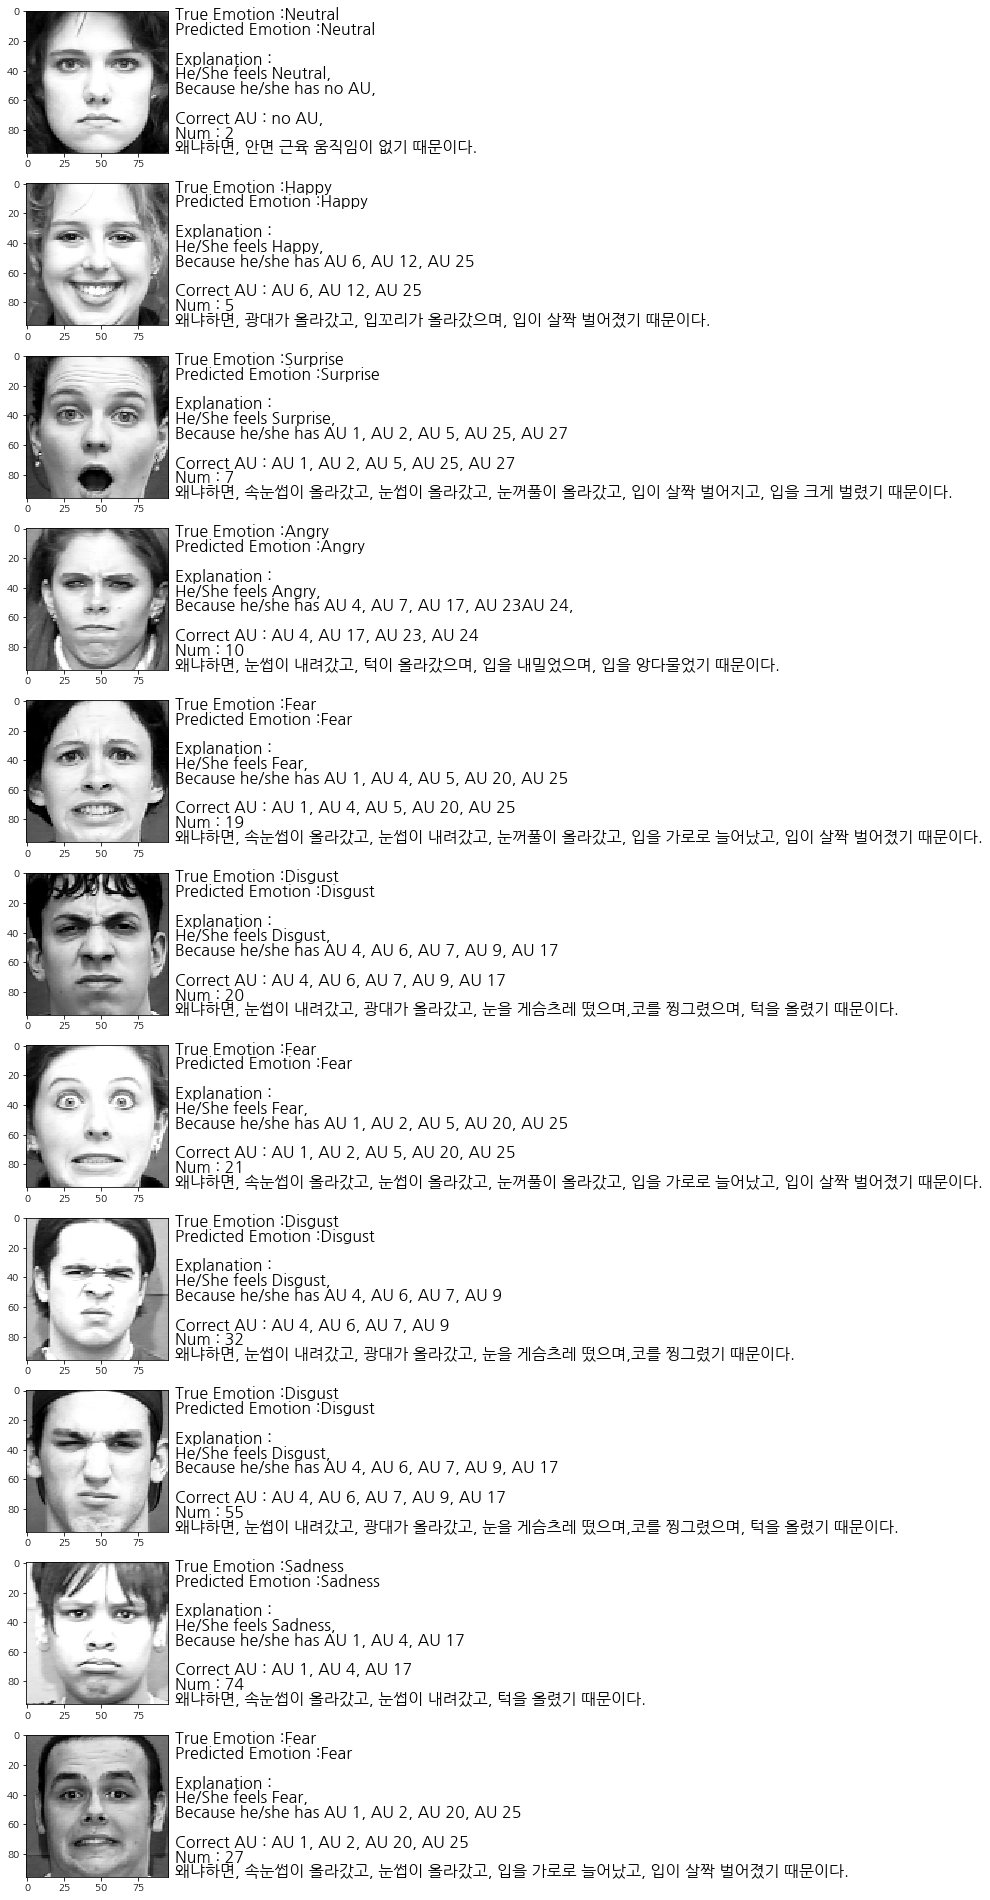

In [84]:
c = 1
data_indices = [2,5,7,10,19,20,21,32,55,74,27]
num_data = len(data_indices)
plt.figure(figsize=(15,num_data*5))
for a in data_indices:
    ax = plt.subplot(num_data*2+1,6,c)
    c = plot_prediction(ax, a, c)

plt.savefig('justification_result.png')

In [51]:
facs_acc_percent = facs_accuracy.applymap(lambda x : x /262*100)

In [52]:
facs_acc_percent = facs_acc_percent.T

In [53]:
facs_acc_percent.columns = ['Accuracy']

In [54]:
facs_pred_df = pd.DataFrame(facs_pred_np, columns=facs.columns)

In [55]:
facs_test_arranged = facs_test.astype(np.int)
facs_test_arranged.index = range(facs_test_arranged.shape[0])

In [56]:
from sklearn.metrics import f1_score
facs_f1_score = {}
for code_num in facs_pred_df.columns:    
    facs_f1_score[int(code_num)] = f1_score(facs_test_arranged[code_num], facs_pred_df[code_num])

In [57]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
facs_precision = {}
for code_num in facs_pred_df.columns:    
    facs_precision[int(code_num)] = precision_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_precision = pd.DataFrame(facs_precision, index=['precision'])

facs_precision = facs_precision.T

facs_acc_percent['Precision'] = facs_precision['precision'].map(lambda x : x * 100)

In [58]:
facs_f1_score = pd.DataFrame(facs_f1_score, index=['f1_score'])

facs_f1_score = facs_f1_score.T

facs_acc_percent['f1_score'] = facs_f1_score['f1_score'].map(lambda x : x * 100)

In [59]:
facs_recall = {}
for code_num in facs_pred_df.columns:    
    facs_recall[int(code_num)] = recall_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_recall = pd.DataFrame(facs_recall, index=['recall'])

facs_recall = facs_recall.T

facs_acc_percent['Recall'] = facs_recall['recall'].map(lambda x : x * 100)

In [60]:
facs_acc_percent

,Accuracy,Precision,f1_score,Recall
0,94.656489,87.323944,89.855072,92.537313
1,95.801527,98.717949,93.333333,88.505747
2,96.183206,95.161290,92.187500,89.393939
4,96.946565,97.058824,94.285714,91.666667
5,95.419847,91.525424,90.000000,88.524590
6,96.946565,95.918367,92.156863,88.679245
7,95.801527,89.189189,85.714286,82.500000
9,99.236641,100.000000,96.153846,92.592593
12,98.473282,100.000000,95.555556,91.489362
15,94.656489,100.000000,53.333333,36.363636


In [62]:
from sklearn.metrics import confusion_matrix

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AU  0
[[186   9]
 [  5  62]]
AU  1
[[174   1]
 [ 10  77]]
AU  2
[[193   3]
 [  7  59]]
AU  4
[[188   2]
 [  6  66]]
AU  5
[[196   5]
 [  7  54]]
AU  6
[[207   2]
 [  6  47]]
AU  7
[[218   4]
 [  7  33]]
AU  9
[[235   0]
 [  2  25]]
AU  12
[[215   0]
 [  4  43]]
AU  15
[[240   0]
 [ 14   8]]
AU  17
[[195   5]
 [  6  56]]
AU  20
[[244   0]
 [  2  16]]
AU  23
[[231   4]
 [  5  22]]
AU  24
[[233   2]
 [  6  21]]
AU  25
[[148   1]
 [  2 111]]
AU  27
[[212   1]
 [  3  46]]


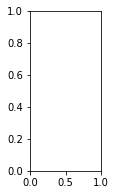

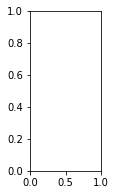

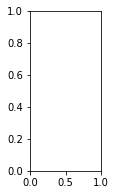

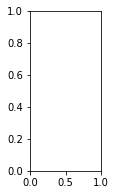

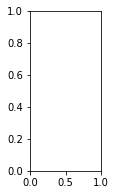

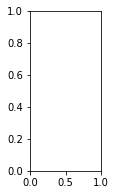

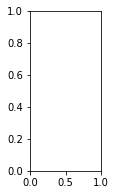

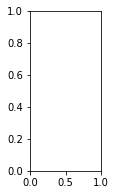

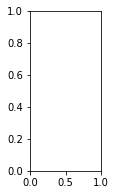

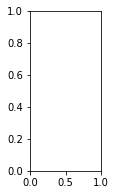

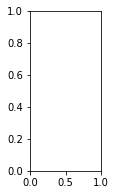

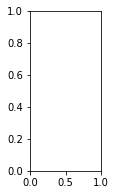

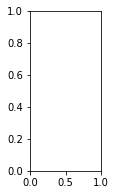

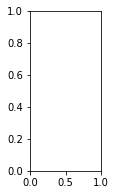

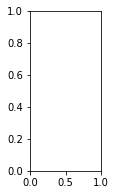

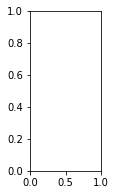

In [70]:
for index, code_num in enumerate(facs_pred_df.columns):
    plt.figure(figsize=(15,10))
    plt.subplot(3,10,index+1)

    print('AU ',code_num)
    print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

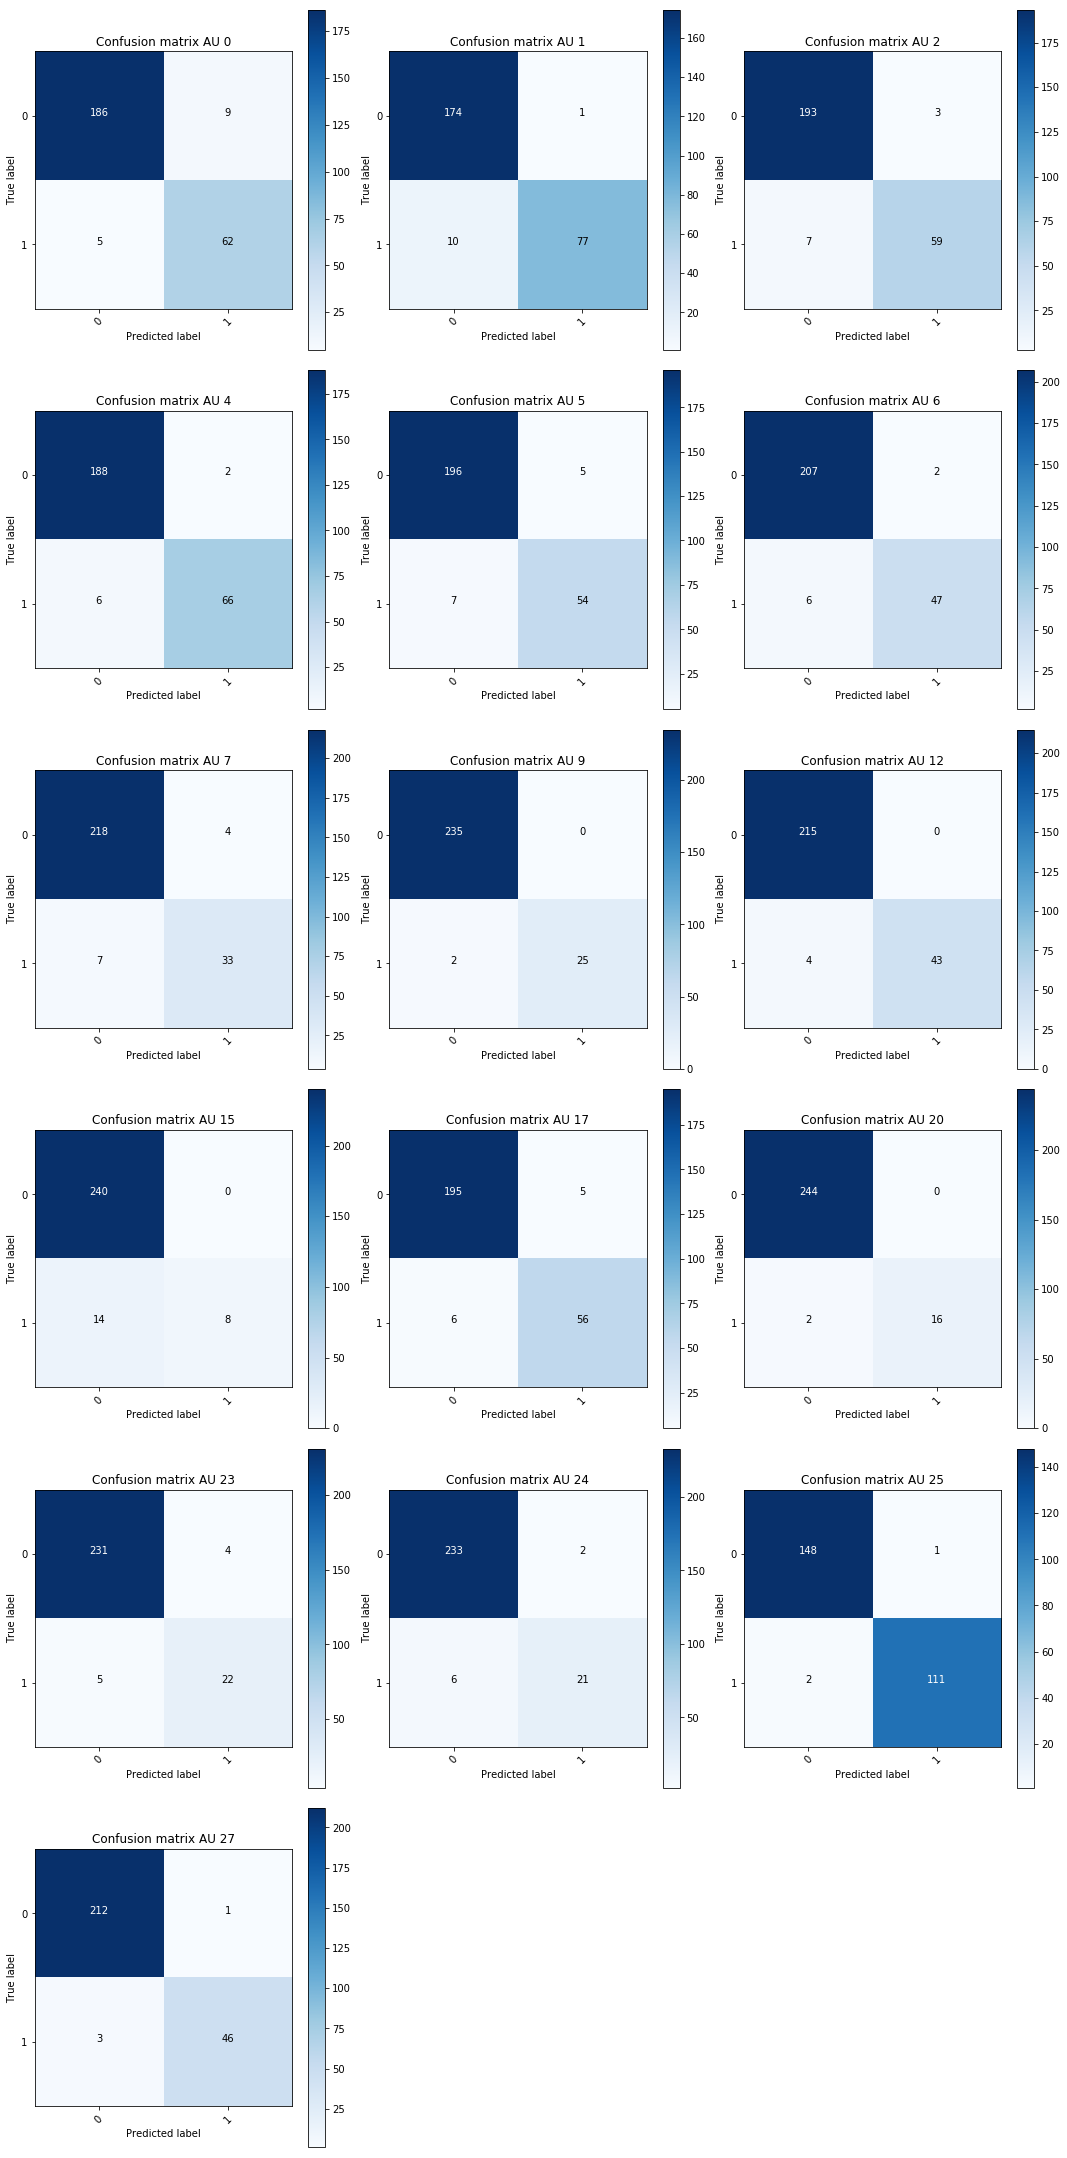

In [85]:
import itertools
class_names = [0, 1]
plt.figure(figsize=(15,50))
for index, code_num in enumerate(facs_pred_df.columns):
    plt.subplot(10,3,index+1)
    cnf_matrix = confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix AU '+str(code_num))

#     print('AU ',code_num)
#     print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

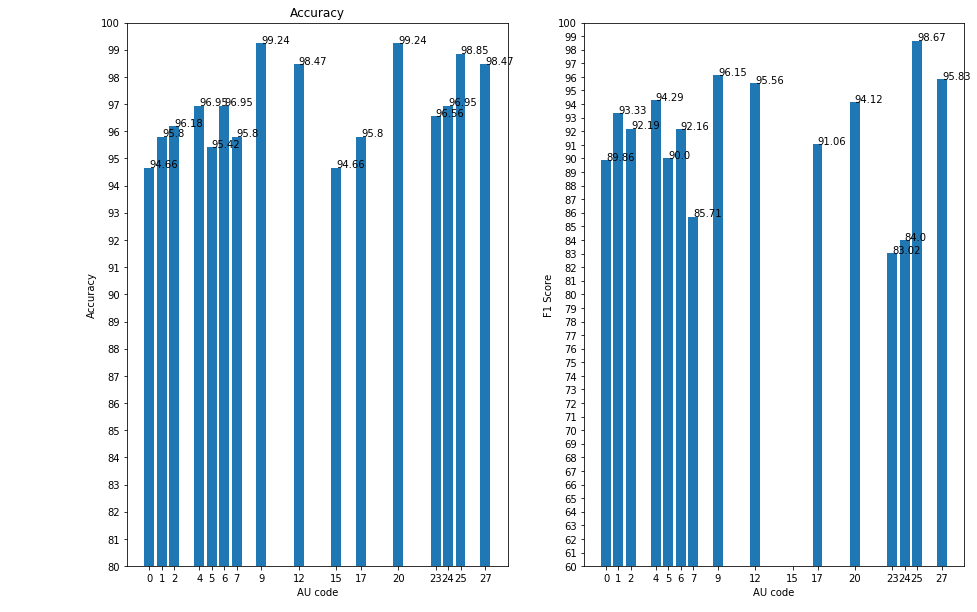

In [61]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('AU code')
plt.ylabel('Accuracy')
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['Accuracy']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))


ax = plt.subplot(1,2,2)
plt.xlabel('AU code')
plt.ylabel('F1 Score')
plt.xticks(facs_acc_percent.index)
plt.ylim((60,100))
plt.yticks(np.arange(60,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['f1_score'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['f1_score']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))

In [213]:
facs_acc_percent.to_csv('result/feature_au_acc.csv')

<Container object of 18 artists>

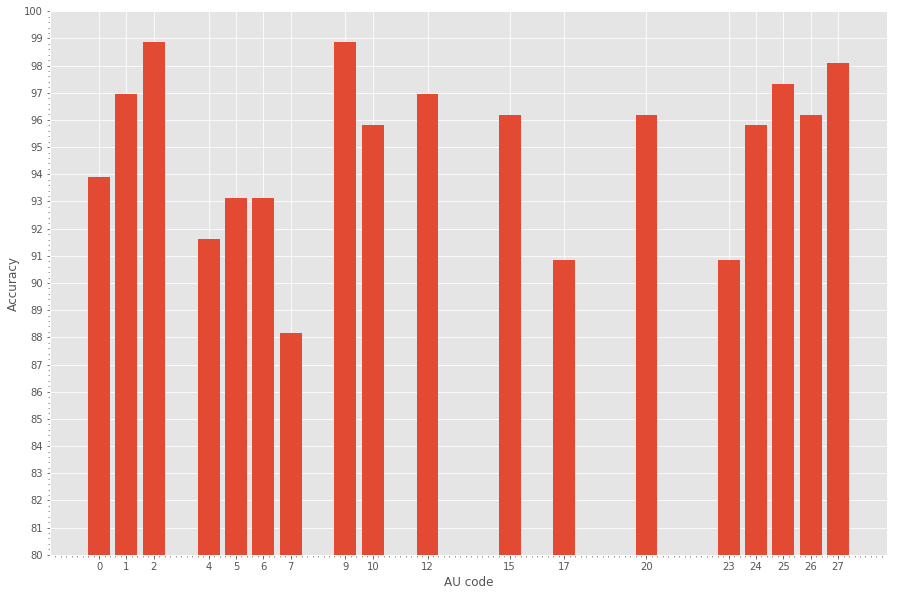

In [128]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.ylabel('Accuracy')
plt.xlabel('AU code')
plt.minorticks_on()
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

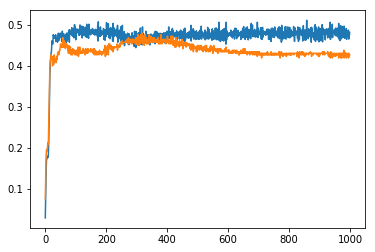

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

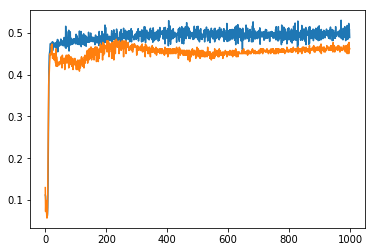

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

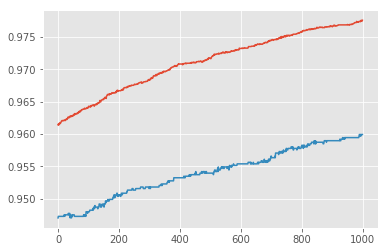

In [165]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [87]:
dense_model.predict(feature_test)

array([[2.18512014e-01, 5.77167809e-01, 7.63536572e-01, ...,
        5.63504756e-04, 9.23508763e-01, 2.13441402e-02],
       [9.82221782e-01, 1.37626287e-02, 2.53648125e-03, ...,
        3.66364897e-04, 1.48531352e-03, 6.00163010e-04],
       [8.52516592e-01, 7.67027810e-02, 1.06651649e-01, ...,
        5.03868284e-03, 1.97427981e-02, 5.98940812e-03],
       ...,
       [2.41851970e-03, 9.72193539e-01, 7.29454577e-01, ...,
        3.35017825e-03, 9.85902429e-01, 8.27229023e-03],
       [6.59153843e-03, 9.47243035e-01, 9.97439861e-01, ...,
        1.01467536e-04, 9.98487234e-01, 9.05066609e-01],
       [9.98491168e-01, 1.74474262e-03, 4.95835033e-04, ...,
        3.89486714e-03, 1.03251274e-04, 4.89191807e-05]], dtype=float32)